In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions.categorical import Categorical

%matplotlib widget

## Gaussian Mixture Model

Let us suppose we are given the weights and heights of Statsville residents. They are three classes of residents in Statsville, women, men and children. The data is unlabelled, meaning we do not know whether a given instance of (height, weight) data is associated with a man or a woman or a child.

If we assume that, considered individually, the distribution of each class is Gaussian. This means heights of men, women and children, each follows 2D Gaussian distribution.

Our task is to come up with a model that can identify the category (man or woman or child) from weight and height.

A Gaussian Mixture Model (GMM) is a weighted combination of a specific number of Gaussian components. They are used to represent naturally multi-classed phenomenons. Each Gaussian component corresponds to a specific class.

A $K$ component GMM is typically used to model a phenomenon with $K$ sub-classes each of which can be modelled by a Gaussian. 

$$
p\left(\vec{x}\right) =\sum_{k=1}^{K} p\left(\vec{x}, Z = k\right) 
                       = \sum_{i=1}^{K} p\left(Z = k\right)$  $p\left(\vec{x} \middle\vert Z= k\right)
                       = \sum_{k=1}^{K} \pi_{k} \; \mathcal{N}\left(\vec{x}; \, \vec{\mu_{k}}, \mathbf{\Sigma}_{k}\right)$$
                       
The $k^{th}$component Gaussian, $\mathcal{N}\left(X = \vec{x}; \, \vec{\mu_{k}}, \mathbf{\Sigma}_{k}\right)$ can be interpreted as the conditional probability, $p\left(X=\vec{x} \middle\vert Z = k\right) $, of  data value $\vec{x}$ occurring, given the $k^{th}$  sub-class.

The weight $\pi_{k}$, can be interpreted as the prior  probability of selecting the $k^{th}$ sub-class, i.e., the fraction of  population belonging to the $k^{th}$ sub-class.

Let us try and model the unlabelled heights and weights data with a 3 component GMM and see if the learnt clusters correspond to the expected categories.

In real life scenarios, we will not know the true values of the parameters (means, variances of the of the Gaussian distributions. However, for the sake of understanding, let us suppose know the true parameters governing the height and width values of the 3 categories.

Specifically: \
$\vec{\mu}_{man}=\begin{bmatrix}
  175\\70
  \end{bmatrix}$,
  $\mathbf{\Sigma}_{man} = \begin{bmatrix}
  8 & 0\\0 & 25
  \end{bmatrix}$,
  $\mathbf{\pi}_{man} = 0.4$, \
$\vec{\mu}_{woman}=\begin{bmatrix}
  152\\55
  \end{bmatrix}$,
  $\mathbf{\Sigma}_{woman} = \begin{bmatrix}
  8 & 0\\0 & 15
  \end{bmatrix}$,
  $\mathbf{\pi}_{woman} = 0.4$\
$\vec{\mu}_{child}=\begin{bmatrix}
  135\\40
  \end{bmatrix}$,
  $\mathbf{\Sigma}_{child} = \begin{bmatrix}
  5 & 0\\0 & 5
  \end{bmatrix}$
  $\mathbf{\pi}_{child} = 0.2$
  
  
We will use these parameters to generate an unlabelled sample of data. And then try to fit a GMM on this data and verify that the learnt GMM essentially learns these parameters

In [2]:
def create_gmm(pi, mu, sigma):
    mix = Categorical(pi)
    components = MultivariateNormal(mu, sigma)
    # A GMM can be viewed as a mixture of multiple normal distribtutions (components). The probabilty of 
    # each component is defined by a categorical distribution, pi (mix) 
    gmm = MixtureSameFamily(mix, components)
    return gmm

In [3]:
# For the purposes of data generation, let us assume we already know the 
# true values of parameters
mu_true = torch.tensor([[175.0, 70.0], 
                        [152.0, 55.0], 
                        [135.0, 40.0]])

sigma_true = torch.tensor([[[8.0, 10.0], [10.0, 25.0]],
                           [[8.0, 0.0], [0.0, 15.0]],
                           [[5.0, 0.0], [0.0, 5.0]]])

pi_true = torch.tensor([0.4, 0.4, 0.2])

data_generator = create_gmm(pi_true, mu_true, sigma_true)

In [4]:
# Let us assume we have a sample of heights and weights from the residents of Statsville
# And our task is to model this data with a GMM that has 3 components.
num_samples = 1000

# Generate the unlabelled samples from the "known" GMM. Note that in real world examples
# we will not have a known GMM. Instead we will just get a sample of unlabelled data.
X = data_generator.sample([num_samples])

In [5]:
def plot_data(X_list, title, colors=['red']):
    fig, ax = plt.subplots()
    for i, X in enumerate(X_list):
        ax.scatter(X[:, 0], X[:, 1], c=colors[i], s=15, edgecolors='black')
    ax.set_title(title)
    ax.set_xlabel("Height in cm")
    ax.set_ylabel("Weight in kg")

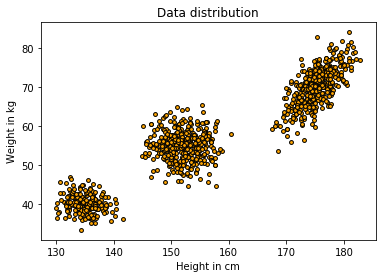

In [6]:
# As we can see clearly, there exist 3 distinct clusters in the underlying data
# We would expect that these clusters correspond to the 3 true classes i.e men, women and children
plot_data([X], "Data distribution", colors=["orange"])

In [7]:
def plot_gmm_components(gmm, num_samples, step):
    pi = gmm.mixture_distribution.probs
    components = gmm.component_distribution
    # Sample num samples from every component distribution
    X_components = components.sample([num_samples])
    num_component_samples = pi * num_samples

    X_list = []
    for i in range(pi.shape[0]):
        # For every component, pick pi * num samples 
        X_list.append(X_components[:, i, :][:int(num_component_samples[i])])
    plot_data(X_list, colors=["red", "blue", "green"], title="Step {}".format(step))

In [8]:
# We want to model this data with a GMM with 3 classes
# Let us start with a random initialization
pi_init = torch.tensor([0.33, 0.33, 0.33])
mu_init = torch.tensor([[100.0, 30.0], [160, 50.0], [200.0, 100.0]])
sigma_init = torch.tensor([[[10.0, 0.0], [0.0, 10.0]],[[10.0, 0.0], [0.0, 10.0]], [[10.0, 0.0], [0.0, 10.0]]])

gmm_init = create_gmm(pi_init, mu_init, sigma_init)

### Maximum Likelihood Estimation of GMM parameters (GMM Fit)

Maximum likelihood estimation of a GMM is done iteratively via Expectation Maximization. We alternately perform the E and the M steps until the likelihood increase is negligible


### E Step
In the E step, we compute the posterior probabilities of the points belonging to the individual clusters

$$\gamma_{ik} =  \frac{\pi_{k} * N(\vec{x}_{i}; \mu_{k}, \Sigma_{k})}{\sum_{k=1}^{K} \pi_{k} * N(\vec{x}_{i}; \mu_{k}, \Sigma_{k})} $$

In [9]:
def E_step(X, gmm):
    pi = gmm.mixture_distribution.probs 
    components = gmm.component_distribution
    n = X.shape[0]
    # In practice, when dealing with exponential functions, we typically work in the log scale
    # This is because the exponential will go to 0 or inf at finite values of x leading to 
    # overflow/ underflow. Working with logarithms leads to numerical stability
    log_gamma_numerators = components.log_prob(X.unsqueeze(1)) + torch.log(pi).repeat(n, 1)
    log_gamma_denominators = torch.logsumexp(log_gamma_numerators, dim=1, keepdim=True)
    log_gamma = log_gamma_numerators - log_gamma_denominators
    gamma = torch.exp(log_gamma)
    return gamma

### M Step
In the M step we compute the new values of the parameters $\mu, \Sigma$ and $\pi$

$$ N_{k} = \sum_{i=1}^{n}  \gamma_{ik} $$
$$\pi_{k} = \frac{N_{k}}{n} $$
$$\vec{\mu}_{k}  = \frac{1}{N_{k}} \sum_{i=1}^{n}  \gamma_{ik} \vec{x}_{i}$$
$${\Sigma}_{k} =  \frac{1}{N_{k}} \sum_{i=1}^{n}  \gamma_{ik} \left( \vec{x}_{i} - \vec{\mu}_{k} \right)  \left( \vec{x}_{i} - \vec{\mu}_{k} \right)^{T}$$

In [10]:
def M_step(X, gmm, gamma):
    pi_old = gmm.mixture_distribution.probs
    components_old = gmm.component_distribution
    
    K = components_old.batch_shape[0]    #number of mixture components
    d = components_old.event_shape[0]    #data dimensionality
    n = X.shape[0]  
    N = torch.sum(gamma, 0)
    pi_new = N / n
    mu_new = ((X.T @ gamma)/N).T
    

    mu_old = components_old.mean
    x_minus_mu = (X.repeat(K, 1, 1) - mu_old.unsqueeze(1).repeat(1, n, 1))
    x_minus_mu_squared = x_minus_mu.unsqueeze(3) @ x_minus_mu.unsqueeze(2)
    sigma_new =  torch.sum(gamma.T.unsqueeze(2).unsqueeze(3) * x_minus_mu_squared, axis=1) / N.unsqueeze(1).unsqueeze(1).repeat(1, d, d)
    return create_gmm(pi_new, mu_new, sigma_new)

In [11]:
def gmm_fit(X, gmm_init):
    curr_gmm = gmm_init
    eps = 1e-4
    prev_likelihood, curr_likelihood = None, None
    step = 0
    while True:
        if curr_likelihood is None:
            curr_likelihood = torch.sum(curr_gmm.log_prob(X))
        # E Step
        gamma = E_step(X, curr_gmm) 
        # M Step
        curr_gmm = M_step(X, curr_gmm, gamma)
        prev_likelihood = curr_likelihood
        # Compute new likelihood
        curr_likelihood = torch.sum(curr_gmm.log_prob(X))
        likelihood_increase = curr_likelihood - prev_likelihood
        if step % 5 == 0:
            plot_gmm_components(curr_gmm, X.shape[0], step)
        step +=1
        if likelihood_increase < eps:
            break
    plot_gmm_components(curr_gmm, X.shape[0], step)
    return curr_gmm

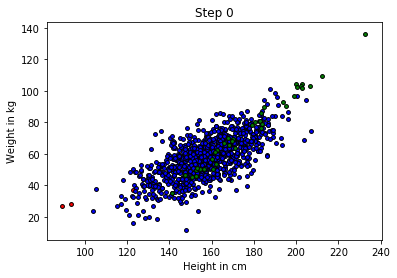

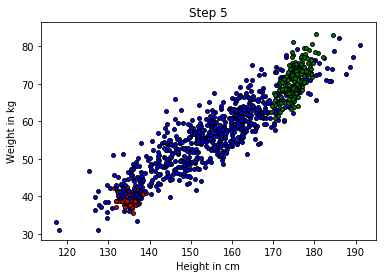

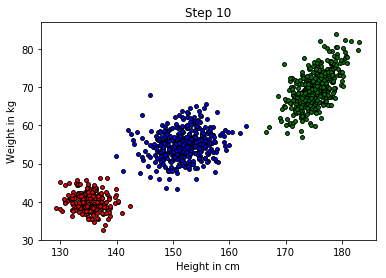

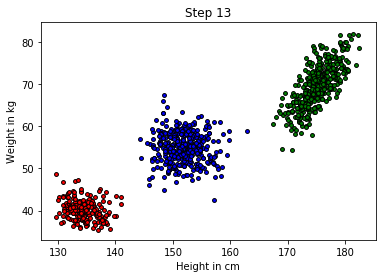

In [12]:
fitted_gmm = gmm_fit(X, gmm_init)

In [13]:
# Let us look at the learnt GMM parameters
# Note that these are similar to the values of pi_init, mu_init and sigma_init
print("Fitted pi: {}".format(fitted_gmm.mixture_distribution.probs))
print("Fitted means: {}".format(fitted_gmm.component_distribution.mean))
print("Fitted sigmas: {}".format(fitted_gmm.component_distribution.covariance_matrix))

Fitted pi: tensor([0.2080, 0.3910, 0.4010])
Fitted means: tensor([[134.8947,  40.2359],
        [152.0206,  55.0424],
        [175.0638,  69.9846]])
Fitted sigmas: tensor([[[ 5.0276, -0.9795],
         [-0.9795,  5.7633]],

        [[ 8.5484, -0.1996],
         [-0.1996, 14.2653]],

        [[ 8.2421,  9.9850],
         [ 9.9850, 24.8230]]])


### Classification

If we have the parameters of the GMM modeling the data, we can predict the class/ component of new datapoints. For that, we need to evaluate the conditional probability  for each class given the input and then choose the class with the highest value of this conditional probability. This conditional probability effectively measures the closeness of  input to the $k^{th}$ cluster, relative to the other clusters.

The conditional probability is defined as follows:
$$ 
p\left(Z = k \middle\vert X = x\right) = \frac{p\left(x, k\right) }{ \sum_{k \in \left\{1, K\right\}} p\left(x, k\right) } = \frac{ \pi_{k} \mathcal{N}\left(\vec{x}; \, \vec{\mu_{k}}, \mathbf{\Sigma}_{k}\right) }{\sum_{k=1}^{K} \pi_{k} \mathcal{N}\left(\vec{x}; \, \vec{\mu_{k}}, \mathbf{\Sigma}_{k}\right) }
$$


In [14]:
def classify(gmm, X):
    gamma = E_step(X, gmm) #Computing the conditional probability is the same as E Step
    classes = gamma.argmax(axis=1)# We assign each point the component with highest probability
    return classes

In [15]:
X_new = torch.tensor([[135.0, 40.0], [152.0, 55.0], [175.0, 70.0]])
assert torch.equal(classify(fitted_gmm, X_new), torch.tensor([0, 1, 2]) )